## Hodgkin-Huxley model with one channel in response to several voltage-clamps protocols
### Channel identity. ICG id: 1707, ModelDB id: 2488

In [29]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt

## Voltage-clamp protocol

In [48]:
prot = ['v_act','v_inact','v_deact','v_ap','v_ramp']
p = 0
protocols = \
pd.read_csv('~/Documents/repos/lfi-models/lfimodels/channelomics/protocols/k_channels/'+prot[p]+'.dat',sep='\t')
protocols = protocols.drop(protocols.columns[-1],axis=1)

# extract voltages and time
protocols1 = protocols.values

V = protocols1[:,1:].T
t = protocols1[:,0]   # attention: time step varies, but we will assume that it is constant
tstep = np.mean(np.diff(t)) # ms

## Parameters and kinetics

In [49]:
# parameters
celsius = 37    # original temperature
temp = 23       # reference temperature
q10 = 2.3       # temperature sensitivity
tadj = q10**((celsius - temp)/10)

# length and diameter equal to 20 um
A_soma = np.pi*((20.*1e-4)**2)  # cm2

C = 1 # uF/cm2

g_L = 3.334e-2 # mS/cm2
E_L = -80 # not sure which one is used in Podlaski et al. 2017, mV

gbar_K = 1.0 # mS/cm2
E_K = -86.7 # mV

noise_std = 0.001

###############################################################################
# kinetics
def efun(z):
    ind = np.abs(z) < 1e-4
    efun1 = z*1.
    efun1[ind] = 1 - z[ind]/2
    efun1[~ind] = z[~ind] / (np.exp(z[~ind]) - 1)
    return efun1

def alpha_n(x):
    v1 = x - 25
    return 0.02 * 9 * efun(-v1/9)
    
def beta_n(x):
    v1 = x - 25
    return 0.002 * 9 * efun(v1/9)

def tau_n(x):
    return 1/(alpha_n(x) + beta_n(x))
def n_inf(x):
    return alpha_n(x)/(alpha_n(x) + beta_n(x))

## Voltage-clamp simulation

In [50]:
t_sim = time.time()

n = np.zeros_like(V)

n[:,0] = n_inf(V[:,0])

len_n = len(n[:,0])

for i in range(1, t.shape[0]):
    n_inf1 = n_inf(V[:,i-1])+noise_std*np.random.randn(len_n)/(tstep**0.5)
    n[:,i] = n_inf1+(n[:,i-1]-n_inf1)*np.exp(-tstep*tadj/tau_n(V[:,i-1]))
    
print(time.time() - t_sim)


fact_inward = 1 # inward current pre-multiplied by -1 (see page 15 of Podlasky et al. 2017)

I_K = fact_inward*tadj*gbar_K*n*(V-E_K)
I_K = I_K/np.max(I_K)
# I_L = tadj*g_L*(V-E_L)
# I_tot = (I_K + I_L)/np.max(I_K + I_L)

3.7861359119415283


## Plot

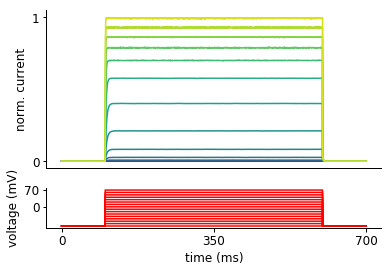

In [51]:
num_levels = len(V[:,0])
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_levels) for i in range(num_levels)]

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_levels):
    plt.plot(t,I_K[i,], color = col1[i])
plt.ylabel('norm. current')
ax.set_xticks([])
ax.set_yticks([0, 1.001*np.max(I_K)])

ax = plt.subplot(gs[1])
for i in range(num_levels):
    plt.plot(t, V[i,],'r')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

duration = np.max(t)
ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, np.max(V)])

plt.show()

## Checking model implementation against it (attention: discrepancy in temporal resolution)

In [52]:
from lfimodels.channelomics.Channel import Channel
n_params = 4
cython = True
m = Channel(channel_type='k',n_params=n_params,cython=cython)

import numpy as np
t_sim = time.time()
out = m.gen_single(np.array([9, 25, 0.02, 0.002]))
print(time.time() - t_sim)

import matplotlib.pyplot as plt
%matplotlib inline

K2 = out[prot[p]]['data']
t2 = out[prot[p]]['time']

0.883587121963501


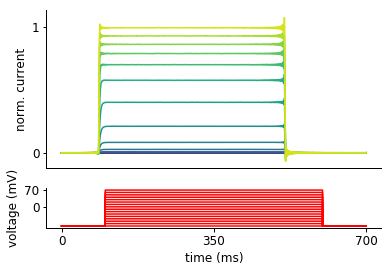

In [53]:
num_levels = len(V[:,0])
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_levels) for i in range(num_levels)]

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_levels):
    plt.plot(t2, K2[i,], color = col1[i])
plt.ylabel('norm. current')
ax.set_xticks([])
ax.set_yticks([0, 1.001*np.max(I_K)])

ax = plt.subplot(gs[1])
for i in range(num_levels):
    plt.plot(t, V[i,],'r')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

duration = np.max(t)
ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, np.max(V)])

plt.show()